In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import shutil
import torch
from torch import nn
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F
import random
import time

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [2]:
class ECGDataset(torch.utils.data.Dataset):
    
    def __init__(self,path):
        self.data=pd.read_csv(path,header=None)
        
    def __getitem__(self,idx):
        x=self.data.loc[idx,:186].values # removed the label
        return x
    
    def __len__(self):
        return len(self.data)
        

torch.Size([64, 187]) torch.float64


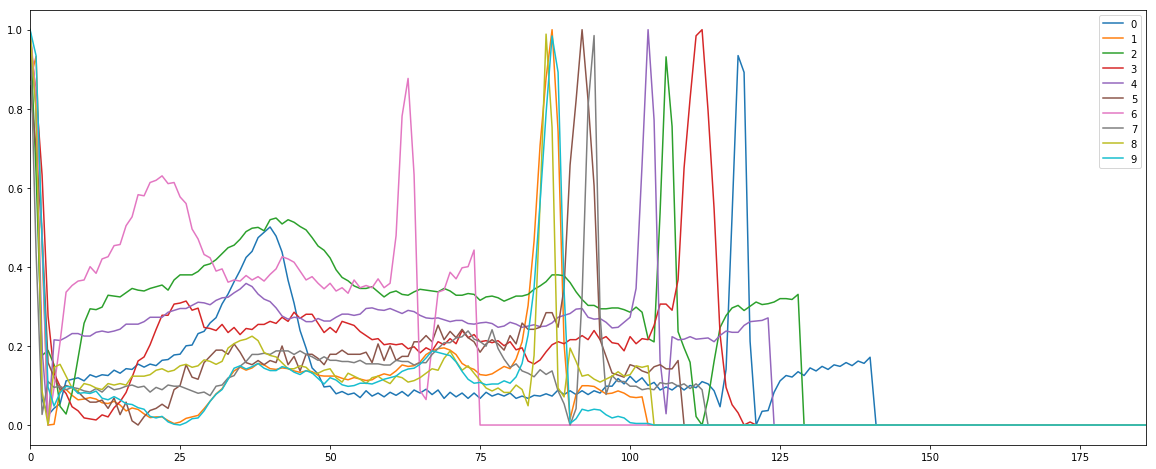

In [3]:
root_path="../input/ecg-data-mit-arrhythmia-ptb"
cuda=torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
    
class opt:
    batch_size=64
    workers=2
    lr=0.001
    normal_train_path=root_path+"/normal_train.csv"
    normal_valid_path=root_path+"/normal_valid.csv"
    patient_valid_path=root_path+"/patient_valid.csv"
    

normal_train_dset=ECGDataset(opt.normal_train_path)
trainloader=torch.utils.data.DataLoader(normal_train_dset,
                                       batch_size=opt.batch_size,
                                       shuffle=True,
                                        num_workers=opt.workers)

for x in trainloader:
    print(x.shape,x.dtype)
    x=x.numpy()
    x=pd.DataFrame(x)
    x.iloc[:10,:].T.plot(figsize=(20,8))
    plt.show() #plot to check the data pipeline is working well
    break

In [8]:
class KLAutoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #conv1d(in_channel,out_channel,kernel_size,stride,padding,bias=True,)
        #input=batch_size*187*1
        self.Encoder=nn.Sequential(
            
            nn.Conv1d(1,2,8),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*90*2
            
            nn.Conv1d(2,4,11),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*40*4
            
            nn.Conv1d(4,8,11),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*15*4
            
            nn.Conv1d(8,16,6),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*5*4
            
            nn.Conv1d(16,32,5),
            nn.Sigmoid(),#batch_size*1*32
        )
        
        #convtranspose1d(in_channel,out_channel,kernel_size,stride,padding,output_padding,bias=True)
        #input=batch_size*1*32
        self.Decoder=nn.Sequential(
            
            nn.ConvTranspose1d(32,16,15,1,0),#batch_size*15*16
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(16,8,12,2,0),#batch_size*40*8
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(8,4,12,2,0),#batch_size*90*4
            nn.Sigmoid(),
            
            nn.ConvTranspose1d(4,2,12,2,5),#batch_size*180*2
            nn.Sigmoid(),
            
            nn.ConvTranspose1d(2,1,8,1,0),#batch_size*180*1
            nn.Sigmoid(),
        )
        
    def forward(self,inp):
        inp=inp.view(-1,1,187)
        latent_vector=self.Encoder(inp)
        fake_signal=self.Decoder(latent_vector)
        
        return fake_signal.view(-1,187),latent_vector.view(-1,32)

In [9]:
network=KLAutoencoder().to(device)
optimizer=optim.Adam(network.parameters(),lr=opt.lr)

def loss_function(out,real):
    pred,latent=out[0],out[1]
    z=torch.rand(latent.size(0), 32,device=device)
    
    mse=F.mse_loss(pred,real,reduction="sum")
    kld=F.kl_div(latent,z,reduction="batchmean")
    
    return mse+kld

In [6]:
total_loss=[]
network.train()
t1=time.time()
for epoch in range(30):
    loss_count=0
    for i,signal in enumerate(trainloader):

        signal=signal.to(device).float()
        
        output=network(signal)
        loss=loss_function(output,signal)
        loss_count+=loss.item()
        
        network.zero_grad()
        loss.backward()
        optimizer.step()
    
    total_loss.append(loss_count)
    if(epoch%10==0):
        print("Epoch : {} Loss : {}".format(epoch,loss_count))
        torch.save(network.state_dict(),"klconv_epoch_{}.pt".format(epoch))
    
t2=time.time()
time_taken=(t2-t1)/60
print(f"Total Time Taken : {time_taken:.2f}")

Epoch : 0 Loss : 418315.3711338043
Epoch : 1 Loss : 186626.06310081482
Epoch : 2 Loss : 121020.98497009277
Epoch : 3 Loss : 85707.61451530457
Epoch : 4 Loss : 67034.09596061707
Epoch : 5 Loss : 55334.830406188965
Epoch : 6 Loss : 48724.68253517151
Epoch : 7 Loss : 43313.58211231232
Epoch : 8 Loss : 39743.91327571869
Epoch : 9 Loss : 37286.84679603577
Epoch : 10 Loss : 34415.767088890076
Epoch : 11 Loss : 32740.149335861206
Epoch : 12 Loss : 31151.522787094116
Epoch : 13 Loss : 30048.645811080933
Epoch : 14 Loss : 28765.283241271973
Epoch : 15 Loss : 27524.72378540039
Epoch : 16 Loss : 26773.717849731445
Epoch : 17 Loss : 25778.024118423462
Epoch : 18 Loss : 24994.623556137085
Epoch : 19 Loss : 24468.572025299072
Epoch : 20 Loss : 23481.97159576416
Epoch : 21 Loss : 23109.05920791626
Epoch : 22 Loss : 22194.34634590149
Epoch : 23 Loss : 21587.49893951416
Epoch : 24 Loss : 21385.085304260254
Epoch : 25 Loss : 20752.33065700531
Epoch : 26 Loss : 20736.32375049591
Epoch : 27 Loss : 19973.0

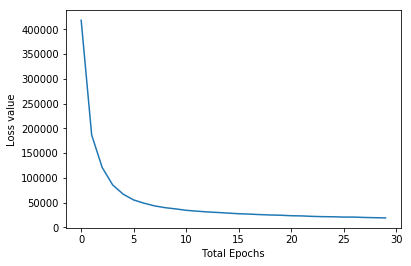

In [7]:
plt.plot(list(range(len(total_loss))),total_loss)
plt.xlabel("Total Epochs")
plt.ylabel("Loss value")
plt.show()